In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pupil_import import * # THIS IMPORTS NUMPY AS NP FFS
from copy import deepcopy
import MegaScreen
import pickle

In [2]:
import jax
import jax.numpy as np
import numpy as onp
from jax import grad, jacfwd, jacrev, jit, value_and_grad
from jax.ops import index, index_add, index_update

In [3]:
def JAX_model(x, y, args=None):
    pupil = args['pupil']
    aperture = args['aperture']
    npix = args['npix']
    wl = args['wl']
    fl = args['fl']
    pix_size = args['pix_size']
    tf_size = args['tf_size']

    # Calcualtions
    size_out = args['size']
    phase_scale = 2 * np.pi * aperture * pix_size / fl
    fact = tf_size/size_out
    c = tf_size//2
    s = npix//2
    
    # Off axis stars, create phase slope
    r_pix = np.hypot(x, y) # Distance from off axis (pixels)
    phi_rot = np.arctan2(y, x) # Coordiante rotation angle
    delta_phase = phase_scale * r_pix / wl # Change in phase across the aperture
    eps = 0.0001
    phase_slope = np.linspace(eps, delta_phase + eps, size_out, endpoint=False)
    Xs, Ys  = np.meshgrid(phase_slope, phase_slope)
    Rs = np.hypot(Xs, Ys)
    Phis = np.arctan2(Ys, Xs)
    phase_out = Rs * np.cos(Phis + phi_rot)
    
    # Add phase to pupil
    pupil_phase = np.angle(pupil) + phase_out    
    pupil_mag = np.abs(pupil)
    pupil_new = pupil_mag * np.exp(1j * (pupil_phase))    
    
#     FOR FLOAT 32
    array_out = np.zeros((tf_size,tf_size),dtype=np.complex64)
#     # FOR FLOAT 64
#     array_out = np.zeros((tf_size,tf_size),dtype=np.complex128)
    
    array_out = index_update(array_out, index[0:size_out, 0:size_out], pupil_new)

    # Perform FT
    wf = np.fft.fftshift(np.fft.fft2(array_out))
    PSF = np.abs(wf)**2
    PSF_norm = PSF/np.sum(PSF)    
    PSF_out = PSF_norm[c-s:c+s, c-s:c+s]

    return PSF_out

def ADAM(X, grad, LR, i, m, v, b1=0.9, b2=0.999, epsilon=1):
    m = b1 * m + (1 - b1) * grad
    v = b2 * v + (1 - b2) * np.power(grad, 2)
    m_hat = m / (1 - np.power(b1, i+1))
    v_hat = v / (1 - np.power(b2, i+1))
    X_new = X - LR * m_hat / (np.sqrt(v_hat) + epsilon)
    return X_new, m, v

def square_super_gaussian(sigma, power, npix):
    c = npix/2
    xs = np.linspace(-c, c, npix, endpoint=False)
    exponent = ((xs**2) / (2*sigma**2))**power
    Gx = np.tile(np.exp(-exponent), npix).reshape(npix, npix)
    Gy = np.repeat(np.exp(-exponent), npix).reshape(npix, npix)
    return Gx*Gy

def get_OTF(image):
    return np.abs(np.fft.fftshift(np.fft.fft2(image)))

def get_radial(npix):
    c = npix//2
    xrange = np.arange(-c, c)
    X, Y = np.meshgrid(xrange, xrange)
    R = np.hypot(X, Y)
    return R

def get_outer_sum(array, r):
    R = get_radial(array.shape[0])
    sum_out = np.sum(array[R > r])
    return sum_out

def get_FF_err(X, FF_true, npix):
    FF_inv = X.reshape([npix, npix])
    FF_new = 1/FF_inv
    FF_residual = FF_true - FF_new
    FF_err = np.sum(np.abs(FF_residual))
    return FF_residual, FF_err

def error(X, args=None):
    images = args['images']
    npix = args['npix']
    r = args['r']
    
    FF_inv = X.reshape([npix, npix])
    OTF_outer_sum = 0
    for image in images:
        corrected_image = FF_inv * image
        image_OTF = get_OTF(corrected_image)
        OTF_outer_sum += get_outer_sum(image_OTF, r)

    return OTF_outer_sum

err_grad = value_and_grad(error)

In [4]:
# Define simulation parameters
aperture = 0.018 # 18mm
wl = 525e-9 # 525nm - Central green band on RBP cam
fl = 0.15 # 15cm camera lens
npix = 256 # Only simulate central region
pix_size = 1.12e-6 # 1.12 microns
tf_size = 2**9

In [5]:
pupil_in = pupil_from_fits("pupil.fits")
plate_scale = pix_size/fl    # Radians per pixel
spatial_freq = wl/aperture
scale_factor = spatial_freq/plate_scale
size_out = int(tf_size/scale_factor)
print(size_out)
pupil = scale_pupil(pupil_in, size_out)
np.save("pupil.npy", pupil)

131


In [6]:
seed = 0
nimages = 10

In [7]:
generator=MegaScreen.MegaScreen(windowShape=(131, 131), dx=1e3)

In [8]:
# Make noisy pupils
rand_pupils = []
for rand_phase in range(nimages):
    rand_pupils.append(np.abs(pupil) * np.exp(1j * next(generator)))

/suphys/ldes9555/anaconda3/envs/main/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


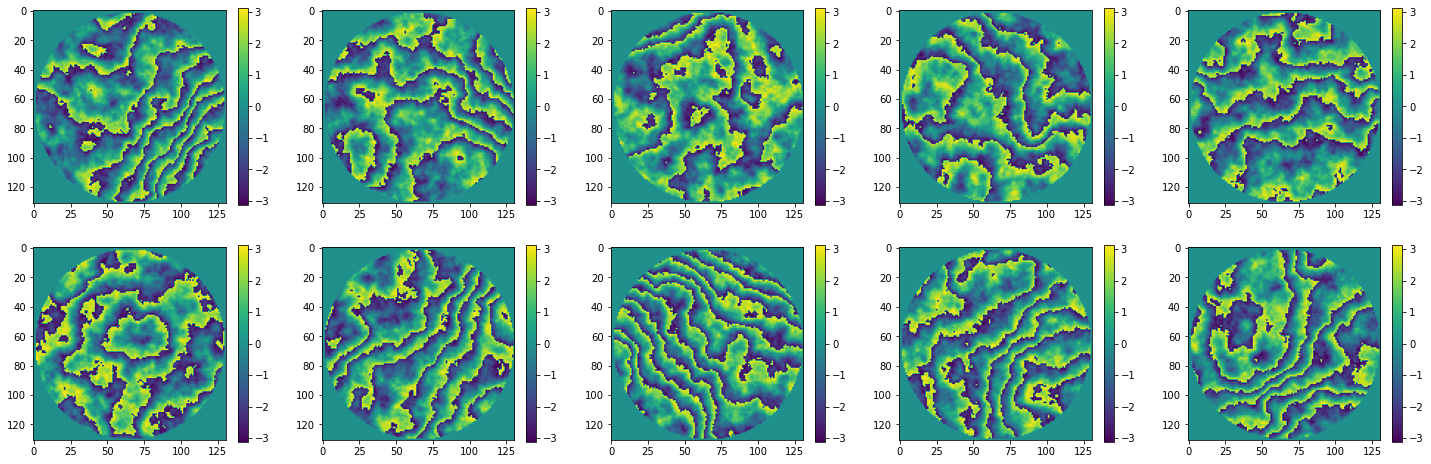

In [9]:
plt.figure(figsize=(25, 8))

for i in range(nimages):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.abs(rand_pupils[i])*np.angle(rand_pupils[i]))
    plt.colorbar()
    
plt.show()

In [10]:
args = {
    'pupil': rand_pupils[0],
    'aperture': aperture,
    'npix': npix,
    'wl': wl,
    'fl': fl,
    'pix_size': pix_size,
    'tf_size': tf_size,
    'size': size_out,
}

# Generate PSF filter
wings_filter = square_super_gaussian(sigma=80, power=10, npix=npix)

PSFs = []
PSF_OTFs = []
filtered_PSFs = []
filtered_PSF_OTFs = []
for i in range(len(rand_pupils)):
    args['pupil'] = rand_pupils[i]
    PSF = JAX_model(0, 0, args=args)
    filtered_PSF = wings_filter * PSF
    PSF_OTF = get_OTF(PSF)
    filtered_PSF_OTF = get_OTF(filtered_PSF)
    
    PSFs.append(PSF)
    PSF_OTFs.append(PSF_OTF)
    filtered_PSFs.append(filtered_PSF)
    filtered_PSF_OTFs.append(filtered_PSF_OTF)
    
PSF = PSFs[0]
PSF_OTF = PSF_OTFs[0]
filtered_PSF = filtered_PSFs[0]
filtered_PSF_OTF = filtered_PSF_OTFs[0]

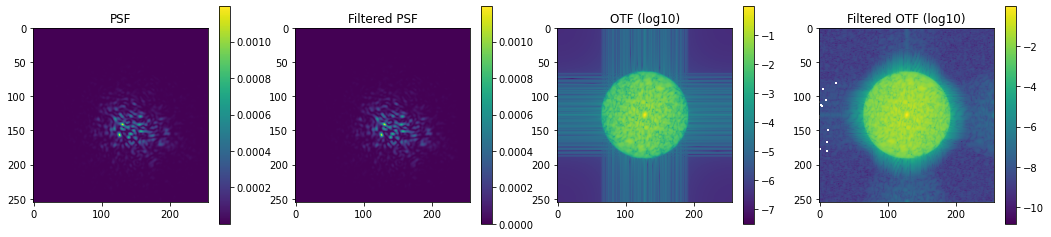

In [12]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 4, 1)
plt.imshow(PSF)
plt.title("PSF")
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(filtered_PSF)
plt.title("Filtered PSF")
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(np.log10(PSF_OTF))
plt.title("OTF (log10)")
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(np.log10(filtered_PSF_OTF))
plt.title("Filtered OTF (log10)")
plt.colorbar()

plt.show()

---

## Make FF and observe PSF/OTF

In [13]:
FF_true = (np.ones(npix**2) - 0.2*onp.random.rand(npix**2)).reshape([npix, npix])
images = np.array(PSFs) * FF_true * wings_filter
OTFs = np.abs(np.fft.fftshift(np.fft.fft2(images)))

image = images[0]
OTF = OTFs[0]

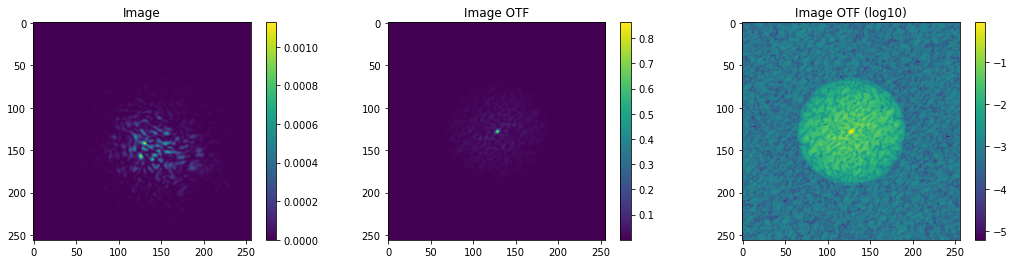

In [14]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Image")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(OTF)
plt.title("Image OTF")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(np.log10(OTF))
plt.title("Image OTF (log10)")
plt.colorbar()

plt.show()

---

### Generate image sum and make sure there is some power on all pixels

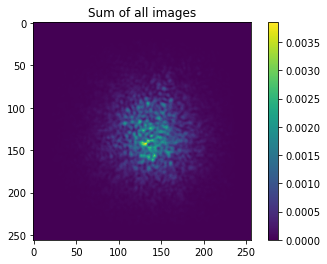

In [15]:
im_sum = np.zeros(images.shape[1:])
for i in range(len(images)):
    im_sum += images[i]
    
plt.imshow(im_sum, vmin=0)
plt.colorbar()
plt.title("Sum of all images")
plt.show()

---

### Define the GD functions

In [16]:
GD_args_in = {
    'images': images,
    'npix': npix,
    'r': (size_out/2) + 1
}

In [24]:
X = 1.1*np.ones(npix**2)
LR = 1e-1
m, v = 0, 0

errs = []
Xs = []

epochs = [250, 500, 750, 1000]
for i in tqdm(range(epochs[-1])):
    err, grads = err_grad(X, args=GD_args_in)
    errs.append(err)
    Xs.append(X)
    X, m, v = ADAM(X, grads, LR, i, m, v)
    
    if i in epochs:
        LR *=0.1
    
errs = np.array(errs)

In [25]:
FFs_out = []
OTFs_out = []
FF_errs = []
FF_residuals = []
for i in tqdm(range(len(Xs))):
    FF = 1/Xs[i].reshape([npix, npix])
    FFs_out.append(FF)
    OTFs_out.append(get_OTF(images[i] * FF * wings_filter))
    FF_res, FF_err = get_FF_err(Xs[i], FF_true, npix)
    FF_residuals.append(FF_res)
    FF_errs.append(FF_err)

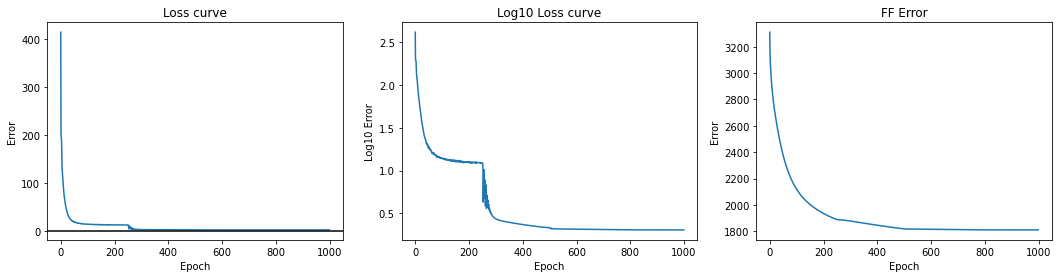

In [26]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(errs)
plt.axhline(0, c='k')
plt.title("Loss curve")
plt.ylabel("Error")
plt.xlabel("Epoch")

plt.subplot(1, 3, 2)
plt.plot(np.log10(errs))
plt.title("Log10 Loss curve")
plt.ylabel("Log10 Error")
plt.xlabel("Epoch")

plt.subplot(1, 3, 3)
plt.plot(FF_errs)
plt.title("FF Error")
plt.ylabel("Error")
plt.xlabel("Epoch")

plt.show()

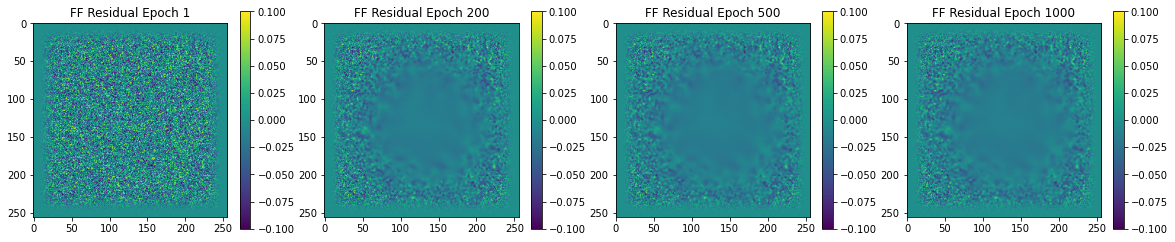

In [27]:
iths = [1, 200, 500, 1000]

plt.figure(figsize=(20, 4))

for i in range(len(iths)):
    plt.subplot(1, 4, i+1)
    FF_res = FF_residuals[iths[i]-1] * wings_filter
#     v = np.max(np.abs(FF_res))
    v = 0.1
    plt.imshow(FF_res, vmin=-v, vmax=v)
    plt.title("FF Residual Epoch {}".format(iths[i]))
    plt.colorbar()

plt.show()

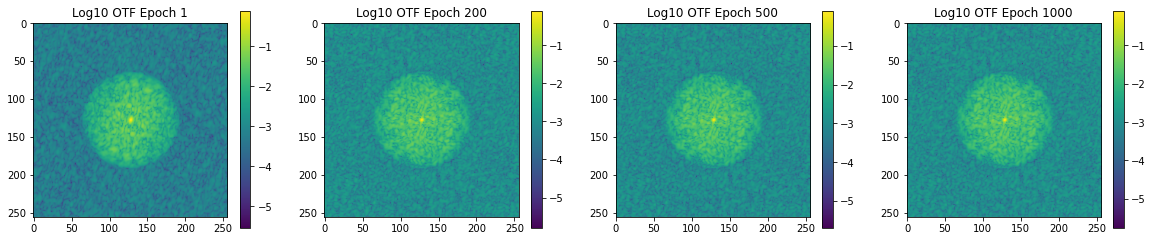

In [28]:
plt.figure(figsize=(20, 4))

for i in range(len(iths)):
    plt.subplot(1, 4, i+1)
    plt.imshow(np.log10(OTFs_out[iths[i]-1]))
    plt.title("Log10 OTF Epoch {}".format(iths[i]))
    plt.colorbar()

plt.show()